# Audio Classification using CNN on **Sonic_Vault Dataset**

## Overview
This project implements an audio classification model using Convolutional Neural Networks (CNNs) in TensorFlow/Keras. The dataset used is `Sonic_Vault`, which contains audio samples categorized into two genres: **news/talk (NPR)** and **music (Classic FM)**. The model is trained to classify these audio samples based on extracted **Mel-Frequency Cepstral Coefficients (MFCCs)**.

## Data Preprocessing
1. **Dataset Preparation**: The metadata is loaded from `metadata.csv`, containing filenames and their corresponding station names.
2. **MFCC Extraction**:
   - The audio is loaded with a sample rate of **22050 Hz**.
   - **50 MFCCs** are extracted for each audio file.
   - Padding or truncation ensures a consistent feature length of **130 frames**.
3. **Label Encoding**:
   - `NPR` is mapped to **label 0** (news/talk).
   - `Classic FM` is mapped to **label 1** (music).

## Model Architecture
The CNN model consists of the following layers:
- **Conv2D (32 filters, 3×3 kernel, ReLU activation)**
- **MaxPooling2D (2×2 pool size)**
- **Dropout (0.3)**
- **Conv2D (64 filters, 3×3 kernel, ReLU activation)**
- **MaxPooling2D (2×2 pool size)**
- **Dropout (0.3)**
- **Flatten layer**
- **Dense (128 neurons, ReLU activation)**
- **Dropout (0.3)**
- **Output layer (Softmax activation for binary classification)**

## Training and Results
- The model was trained for **10 epochs** using the **Adam optimizer** and **categorical crossentropy** loss function.
- **Training and Validation Accuracy**:
  - Initial accuracy fluctuated due to high loss values.
  - Training accuracy reached **100%** by the final epoch.
  - Validation accuracy also reached **100%**, suggesting possible overfitting.
- **Loss Trends**:
  - The training loss decreased steadily.
  - Validation loss showed minor fluctuations but remained low.

## Performance Analysis
1. **Test Accuracy**: **100%**
2. **Test Loss**: **0.1604**
3. **Visualization**:
   - Training and validation accuracy plotted over epochs.
   - Training and validation loss plotted over epochs.

## Overfitting Concerns
Despite achieving perfect accuracy, the model likely suffers from **overfitting** due to:
- A **small dataset size**.
- **Insufficient data augmentation**.
- A **high model complexity** relative to available data.

## Recommendations for Improvement
- **Increase Dataset Size**: Collect more audio samples to improve generalization.
- **Data Augmentation**: Introduce techniques such as time-stretching, pitch shifting, and noise injection.
- **Regularization**: Use techniques like **L2 regularization** or **dropout tuning**.
- **Early Stopping**: Monitor validation loss and stop training when overfitting signs appear.

## Conclusion
The model achieves **high accuracy on training and test data**, but due to the **small dataset size**, it is likely **overfitted**. Future improvements such as **data augmentation, regularization, and larger datasets** can enhance generalization and ensure better real-world performance.

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [4]:
DATASET_DIR = "Sonic_Vault"
METADATA_FILE = os.path.join(DATASET_DIR, "metadata.csv")
SR = 22050            
N_MFCC = 50           
MAX_PAD_LEN = 130     

# Map station to genre label: NPR => news/talk (label 0), Classic_FM => music (label 1)
label_map = {"NPR": 0, "Classic_FM": 1}

In [5]:
def extract_mfcc(file_path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [6]:
metadata = pd.read_csv(METADATA_FILE)

X, y = [], []

for idx, row in metadata.iterrows():
    station = row['Station Name']
    filename = row['Filename']
    file_path = os.path.join(DATASET_DIR, filename)
    mfcc = extract_mfcc(file_path)
    if mfcc is not None:
        X.append(mfcc)
        y.append(label_map.get(station, -1))  

In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
valid_idx = y != -1
X = X[valid_idx]
y = y[valid_idx]

In [9]:
X = X[..., np.newaxis]

In [10]:
y_cat = to_categorical(y, num_classes=2)

print("Dataset shapes:")
print("X:", X.shape)
print("y:", y_cat.shape)

Dataset shapes:
X: (30, 50, 130, 1)
y: (30, 2)


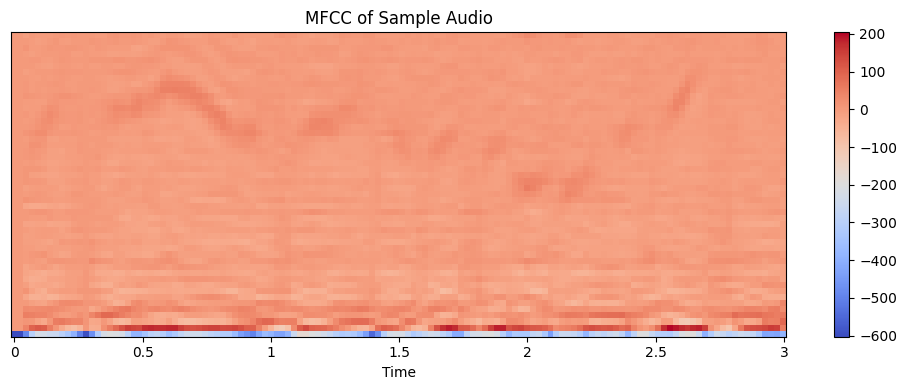

In [11]:
sample_idx = 0  
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[sample_idx, :, :, 0], sr=SR, x_axis='time')
plt.colorbar()
plt.title('MFCC of Sample Audio')
plt.tight_layout()
plt.show()

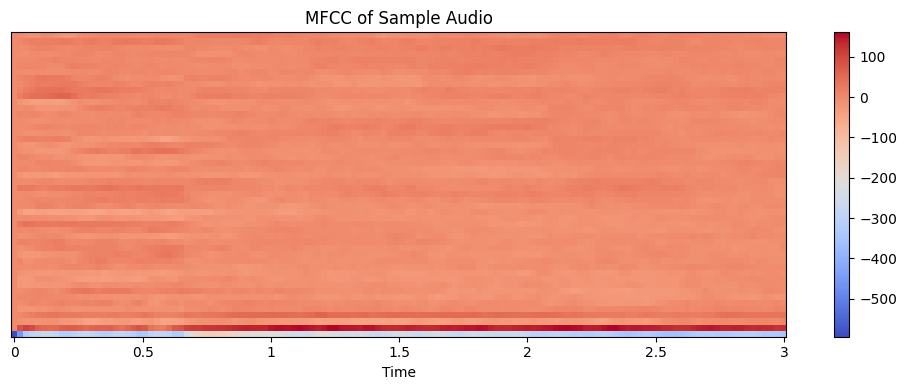

In [12]:
sample_idx = 5 
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[sample_idx, :, :, 0], sr=SR, x_axis='time')
plt.colorbar()
plt.title('MFCC of Sample Audio')
plt.tight_layout()
plt.show()

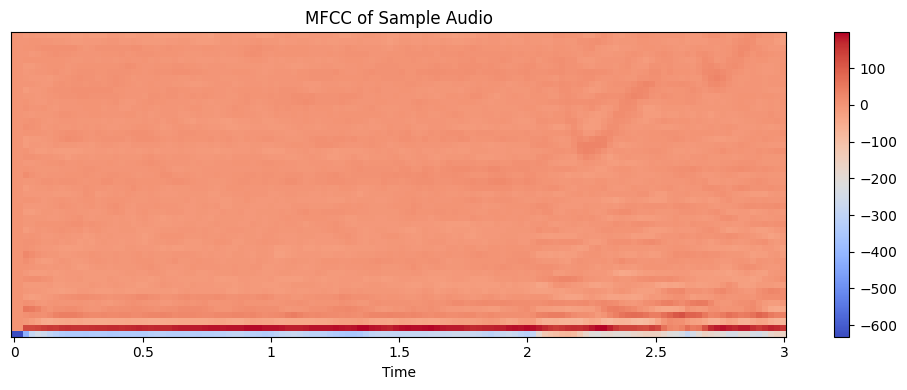

In [13]:
sample_idx = 10
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[sample_idx, :, :, 0], sr=SR, x_axis='time')
plt.colorbar()
plt.title('MFCC of Sample Audio')
plt.tight_layout()
plt.show()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=9)

In [45]:
input_shape = (N_MFCC, MAX_PAD_LEN, 1)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 48, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 24, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 22, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 11, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 11, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 21824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     2,793,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,812,674 (10.73 MB)

 Trainable params: 2,812,674 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/10


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4661 - loss: 27.8644 - val_accuracy: 0.8333 - val_loss: 10.0659
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4411 - loss: 53.8638 - val_accuracy: 0.1667 - val_loss: 22.9833
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6452 - loss: 18.9531 - val_accuracy: 0.8333 - val_loss: 0.3251
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7619 - loss: 1.4084 - val_accuracy: 0.8333 - val_loss: 0.7009
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7565 - loss: 0.7582 - val_accuracy: 0.8333 - val_loss: 0.3619
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7988 - loss: 0.4406 - val_accuracy: 1.0000 - val_loss: 0.1567
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8786 - loss: 0.1845 - val_accuracy: 1.0000 - val_loss: 0.2204
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9482 - loss: 0.1779 - val_accuracy: 1.0000 - val_loss: 0.2100
Epoch 

In [47]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.16038158535957336
Test accuracy: 1.0


#### Test Accuracy= 100%

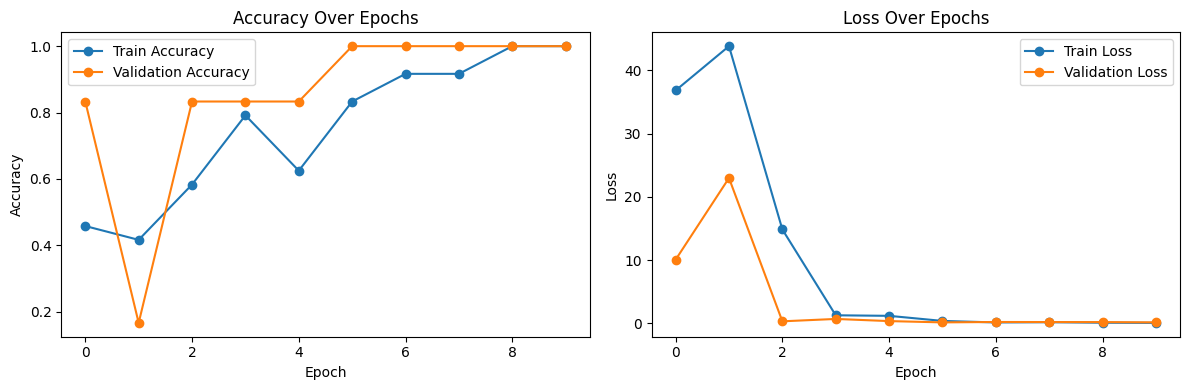

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
